In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

from isca_tools.convection.base import lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
percentile_label = 'Temperature Percentile, $x$'

In [3]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological'}
leg_handlelength = 1.5

## Load data and average over `sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
%%time
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

surf = 'aquaplanet'
ds = get_ds([surf], dailymax=False)[surf]
if surf == 'aquaplanet':
    ds700 = ds.sel(p_ft=700 * 100).copy(deep=False)  # use at the end
    ds = ds.sel(p_ft=500 * 100)  # use for the main analysis
p_ft = float(ds.p_ft)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds['lapse_Dz'] = ds.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.mod_parcel1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']

# Approximations for LNB
# LNB function requires sample as a coordinate not dimension
if 'sample' not in ds.coords:
    ds = ds.assign_coords(sample=("sample", np.arange(ds.sizes["sample"])))
ds['p_lnb'] = isel_float(get_P(ds), ds.klzbs - 1,
                         'lev')  # Offset by -1 because fortran starts with 1, but python starts with 0
ds['p_lnb_approx'] = get_P(ds).isel(lev=ds.lnb_ind)  # lnb estimate from T_parc - T_env

lat_weights = np.cos(np.deg2rad(ds.lat))

CPU times: user 39.2 s, sys: 2.71 s, total: 41.9 s
Wall time: 42.4 s


In [43]:
def get_ds_quant_and_ref(ds, error_thresh=0.25):
    mask_fit = utils.get_valid_mask(ds, error_thresh, None)  # & (ds['p_lnb'] < p_ft)

    # Get rid of variables don't need anymore - those with lev and layer dimensions
    ds = ds.drop_dims(['lev', 'layer'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='sample')
    ds_quant['n_conv_days'] = mask_fit.sum(dim='sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref, mask_fit
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant, ds_ref, mask_conv_valid = get_ds_quant_and_ref(ds)

In [44]:
# Compute sCAPE from averaged quantities as takes too long to compute for each individual day
# Use parcel_def_include_z_approx=False because in this version of parcel definition, we get rid of A_z term
ds_quant['mse_REFHT'] = moist_static_energy(ds_quant.TREFHT, ds_quant.QREFHT, ds_quant.ZREFHT)
ds_quant['mse_ft_sat'] = moist_static_energy(ds_quant.T_ft_env, sphum_sat(ds_quant.T_ft_env, p_ft), ds_quant.Z_ft_env)
ds_quant['epsilon'] = ds_quant['mse_REFHT'] - ds_quant['mse_ft_sat']
get_cape_func = wrap_with_apply_ufunc(get_cape_approx, output_core_dims=[[], []])
ds_quant['sCAPE'] = get_cape_func(ds_quant.TREFHT, ds_quant.rh_REFHT, ds_quant.PREFHT, p_ft, ds_quant.T_ft_env,
                                  ds_quant.epsilon, parcel_def_include_z_approx=False)[0] * 1000

In [45]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat', 'parcel_type')
ds_ref = ds_ref.transpose('tau_lw', 'lat', 'parcel_type')

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [8]:
%%time
ds_sf_num = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc, co2_dim='tau_lw',
                                            lapse_coords='lnp', sCAPE_form=False, numerical=True)
ds_sf_num_cape = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc, co2_dim='tau_lw',
                                                 lapse_coords='lnp', sCAPE_form=True, numerical=True)
ds_sf = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc, co2_dim='tau_lw',
                                        lapse_coords='lnp', sCAPE_form=False)
ds_sf_cape = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc, co2_dim='tau_lw',
                                             lapse_coords='lnp', sCAPE_form=True)

CPU times: user 36.8 s, sys: 259 ms, total: 37 s
Wall time: 37.4 s


In [9]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
ds_sf_num_cape["nl_sum"] = ds_sf_num_cape['scale_factor_nl'] - ds_sf_num_cape['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1
for key in ds_sf_cape:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_num_cape[key] = ds_sf_num_cape[key] - ds_sf_cape[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework, also including sCAPE term as a comparison.

Weighting is slightly different in that not same amount of convective days at each latitude for each quant. So for each quant, preferentially weight latitudes with more convective days.

In [10]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", labels_cont['sCAPE_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory (modParc)'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$')
}

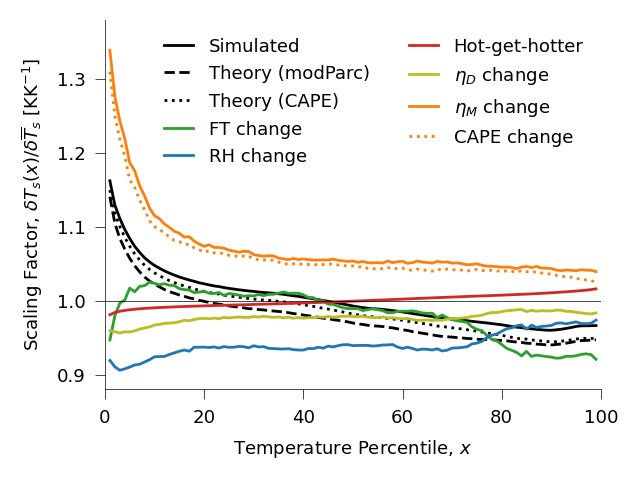

In [69]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
weights_use = ds_quant.n_conv_days.sum(dim='tau_lw')
weights_use = weights_use * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use = weights_use / weights_use.max(dim='lat')

fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for key in ['', '_sum']:
    ax.plot(ds_sf.quant, ds_sf[f"scale_factor{key}"].weighted(weights_use).mean(dim='lat'),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2])
ax.plot(ds_sf_cape.quant, ds_sf_cape[f"scale_factor_sum"].weighted(weights_use).mean(dim='lat'),
        color=style_map[f"scale_factor_sum"][0],
        label='Theory (CAPE)', linestyle=':')
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.abs(ds_sf[key] - 1).weighted(weights_use).mean(dim='lat')) < 0.012:
        continue
    # ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key,
    #         color=style_map[key][0], linestyle=style_map[key][1])
    ax.plot(ds_sf.quant, ds_sf[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
            color=style_map[key][0],
            linestyle=style_map[key][1])
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
ax.plot(ds_sf_cape.quant, ds_sf_cape['sCAPE_change'].weighted(weights_use).mean(dim='lat'),
        color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax.legend(ncol=2, handlelength=leg_handlelength)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig, 6.5)
ax.set_xlim(0, 100)
ax.set_ylim(0.88, 1.38)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

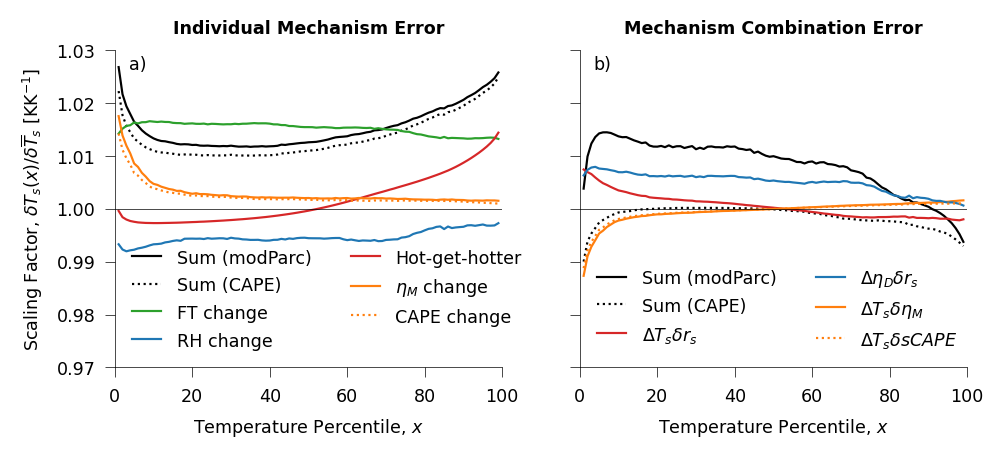

In [56]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_num.quant,
           (ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1).weighted(weights_use).mean(dim='lat'),
           color='k', label='Sum (modParc)')
ax[0].plot(ds_sf_num.quant,
           (ds_sf_num_cape['scale_factor_linear'] - ds_sf_cape['scale_factor_sum'] + 1).weighted(weights_use).mean(
               dim='lat'),
           color='k', linestyle=':', label='Sum (CAPE)')

ax[1].plot(ds_sf_num_cape.quant, ds_sf_num['nl_sum'].weighted(weights_use).mean(dim='lat'),
           color='k', linestyle='-', label='Sum (modParc)')
ax[1].plot(ds_sf_num_cape.quant, ds_sf_num_cape['nl_sum'].weighted(weights_use).mean(dim='lat'),
           color='k', linestyle=':', label='Sum (CAPE)')

# Plot individual mechanism error
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.abs(ds_sf[key] - 1).weighted(weights_use).mean(dim='lat')) < 0.007:
        continue
    if np.nanmax(np.abs(ds_sf_num[key] - 1).weighted(weights_use).mean(dim='lat')) > 0.007:
        ax[0].plot(ds_sf.quant, ds_sf_num[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key):
        continue
    if np.nanmax(np.abs(ds_sf_num[key] - 1).weighted(weights_use).mean(dim='lat')) > 0.007:
        ax[1].plot(ds_sf.quant, ds_sf_num[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])

# Add the CAPE plots
key = 'sCAPE_change'
ax[0].plot(ds_sf_num_cape.quant, ds_sf_num_cape[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
           color=style_map[key][0],
           linestyle=style_map[key][1])
key = 'nl_temp_surf_anom_sCAPE_change'
ax[1].plot(ds_sf_num_cape.quant,
           ds_sf_num_cape['nl_temp_surf_anom_sCAPE_change'].weighted(weights_use).mean(dim='lat'),
           label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

update_linewidth(fig)

# Reorder ax1 legend
handles, labels = ax[1].get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]  # desired new order by index
ax[1].legend([handles[i] for i in order],
             [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)

ax[0].legend(ncol=2, handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
ax[0].set_ylim(0.97, 1.03)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

In [73]:
%%time
# Load in daily max as well for comparison later
ds_quant_daily_max = get_ds(['aquaplanet'], dailymax=True)['aquaplanet']

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds_quant_daily_max['lapse_Dz'] = ds_quant_daily_max.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_quant_daily_max['lapse_Mz'] = ds_quant_daily_max.mod_parcel1_lapse.isel(layer=1) / 1000
ds_quant_daily_max['lapse_D'] = R / g * ds_quant_daily_max.TREFHT * ds_quant_daily_max['lapse_Dz']
ds_quant_daily_max['lapse_M'] = R / g * ds_quant_daily_max.T_ft_env * ds_quant_daily_max['lapse_Mz']
# LZB function requires sample as a coordinate not dimension
if 'sample' not in ds_quant_daily_max.coords:
    ds_quant_daily_max = ds_quant_daily_max.assign_coords(
        sample=("sample", np.arange(ds_quant_daily_max.sizes["sample"])))

ds_quant_daily_max, ds_ref_daily_max, _ = get_ds_quant_and_ref(ds_quant_daily_max)

CPU times: user 15.9 s, sys: 1.88 s, total: 17.8 s
Wall time: 18.5 s


In [74]:
# For single climate, just use tau_lw=0. weights_use was for scaling factor so combines co2 datasets
weights_use_sc = ds_quant.n_conv_days.isel(tau_lw=0)
weights_use_sc = weights_use_sc * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use_sc = weights_use_sc / weights_use_sc.max(dim='lat')

# Need weights for daily max datasets too
weights_use_daily_max = ds_quant_daily_max.n_conv_days.sum(dim='tau_lw')
weights_use_daily_max = weights_use_daily_max * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use_daily_max = weights_use_daily_max / weights_use_daily_max.max(dim='lat')

weights_use_sc_daily_max = ds_quant_daily_max.n_conv_days.isel(tau_lw=0)
weights_use_sc_daily_max = weights_use_sc_daily_max * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use_sc_daily_max = weights_use_sc_daily_max / weights_use_sc_daily_max.max(dim='lat')

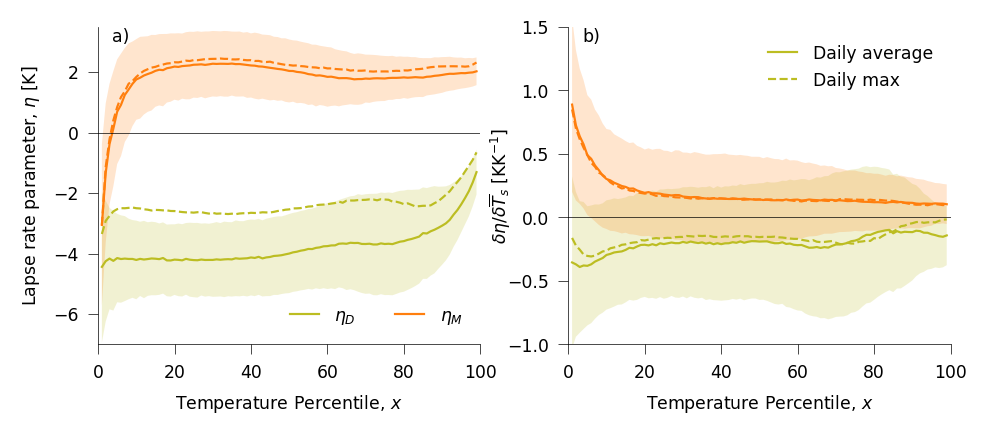

In [79]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])
for i, key in enumerate(['lapse_D', 'lapse_M']):
    ax[0].plot(ds_sf.quant, ds_quant[key].isel(tau_lw=0).weighted(weights_use_sc).mean(dim='lat'),
               color=style_map[f'{key}_change'][0], label=['$\eta_D$', '$\eta_M$'][i])
    ax[0].fill_between(ds_sf.quant,
                       (ds_quant[key] - ds_quant[f"{key}_std"]).isel(tau_lw=0).weighted(weights_use_sc).mean(dim='lat'),
                       (ds_quant[key] + ds_quant[f"{key}_std"]).isel(tau_lw=0).weighted(weights_use_sc).mean(dim='lat'),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")
    var = ds_quant[key].diff(dim='tau_lw').squeeze() / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].plot(ds_sf.quant, var.weighted(weights_use).mean(dim='lat'), color=style_map[f'{key}_change'][0],
               label='Daily average' if i == 0 else None)
    std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(tau_lw=0) ** 2 + ds_quant[f"{key}_std"].isel(tau_lw=1) ** 2
                       ) / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].fill_between(ds_sf.quant,
                       (var - std_diff).weighted(weights_use).mean(dim='lat'),
                       (var + std_diff).weighted(weights_use).mean(dim='lat'),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")

    ax[0].plot(ds_sf.quant, ds_quant_daily_max[key].isel(tau_lw=0).weighted(weights_use_sc_daily_max).mean(dim='lat'),
               color=style_map[f'{key}_change'][0], linestyle='--')
    ax[1].plot(ds_sf.quant, (ds_quant_daily_max[key].diff(dim='tau_lw').squeeze() /
                             ds_ref_daily_max.TREFHT.diff(dim='tau_lw').squeeze()
                             ).weighted(weights_use_daily_max).mean(dim='lat'),
               color=style_map[f'{key}_change'][0], linestyle='--', label='Daily max' if i == 0 else None)
update_linewidth(fig)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(handlelength=leg_handlelength, ncol=2, loc='lower right')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, box_alpha=0, pos_y=-0.5)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[1].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
ax[0].set_ylim(-7, 3.5)
ax[1].set_ylim(-1, 1.5)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)

## LNB Analysis
Idea is to show that cold day amplified warming is due to more days having LNB further from surface than 500hPa

The LNB and Miyawaki 2022 plots coincide nicely indicating a regime change is taking place on these coldest days.

Can also comment on using 700hPa instead of 500hPa - say error a lot higher, and see similar change in % of days p_LNB<p_ft when using p_ft=700hPa

NOTE - This is the fraction of convective days that satisfy the condition.

Have choice of using parcel rising from LCL or from surface.

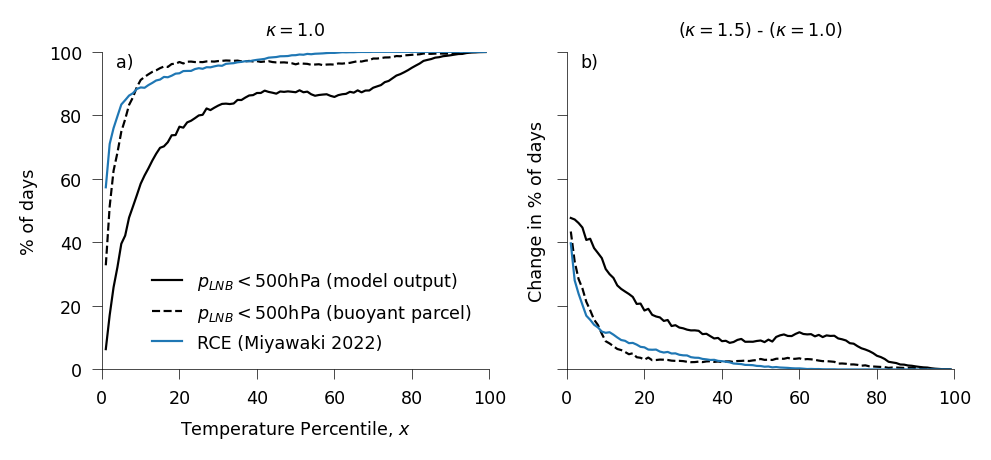

In [82]:
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'lcl'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k, key in enumerate(['p_lnb', 'p_lnb_approx']):
    # for i in range(ds.tau_lw.size):
    #     # ax[0].plot(ds_sf.quant, np.average(ds_quant['p_lnb_approx'].isel(tau_lw=i), axis=1, weights=lat_weights), color=f"C{i}")
    var = (ds[key].where(mask_conv_valid) < ds.p_ft).sum(dim='sample') / mask_conv_valid.sum(dim='sample')
    if 'approx' in key:
        var = var.sel(parcel_type=lnb_buoyancy_method)
    ax[0].plot(ds.quant, var.isel(tau_lw=0).weighted(weights_use_sc).mean(dim='lat') * 100, color=f"k",
               linestyle=[None, '--'][k],
               label='$p_{LNB} < 500$hPa ' + ['(model output)', '(buoyant parcel)'][k])
    ax[1].plot(ds.quant, var.diff(dim='tau_lw').squeeze().weighted(weights_use).mean(dim='lat') * 100, color=f"k",
               linestyle=[None, '--'][k], )
    # Plot 700hPa values - rather than just
    # var = (ds[key]<ds700.p_ft).sum(dim='sample')/ds.sample.size
    # ax[0].plot(ds.quant, np.average(var.isel(tau_lw=0), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    # ax[1].plot(ds.quant, np.average(var.diff(dim='tau_lw').squeeze(), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
var = (ds.lapse_miy2022_M < lapse_miy2022_M_thresh).where(mask_conv_valid).sum(dim='sample') / mask_conv_valid.sum(dim='sample') * 100
ax[0].plot(ds.quant, var.isel(tau_lw=0).weighted(weights_use_sc).mean(dim='lat'), color=f"C0",
           label='RCE (Miyawaki 2022)')
ax[1].plot(ds.quant, var.diff(dim='tau_lw').squeeze().weighted(weights_use).mean(dim='lat'), color=f"C0")
update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days')
ax[0].set_xlabel(percentile_label)
ax[0].set_title('$\kappa=1.0$')
ax[1].set_title('($\kappa=1.5$) - ($\kappa=1.0$)')
label_subplots(fig, ax, box_alpha=0, pos_y=-0.5)
update_fontsize(fig)
plt.show()
# savefig(fig)

In [49]:
# Print useful data to mention - why use 500hPa not 700hPa, more convective days
print(f"Smallest p_LCL: {(lcl_sigma_bolton_simple(ds.rh_REFHT, temp_surf_lcl_calc) * ds.PS).min() / 100:.1f}hPa")
for mask_use in [utils.get_valid_mask(ds, aloft_p_size_thresh=None),
                 utils.get_valid_mask(ds700, aloft_p_size_thresh=None)]:
    var = mask_use.sum(dim=['quant', 'lat', 'sample']) / (ds700.quant.size * ds700.lat.size * ds700.sample.size) * 100
    print(f"% of convective days for p_ft={mask_use.p_ft / 100:.0f}hPa: {np.round(var.values, 1)}")

Smallest p_LCL: 807.7hPa
% of convective days for p_ft=500hPa: [77.3 83.4]
% of convective days for p_ft=700hPa: [20.7 19. ]


## Miyawaki analysis

In [77]:
# area_weighting(ds_quant.lapse_miy2022_M).mean(dim='lat').isel(tau_lw=0).plot()
# area_weighting(-ds_quant.lapse_miy2022_M).mean(dim='lat').diff(dim='tau_lw').squeeze().plot()